In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
titanic_data = pd.read_csv('train.csv')

In [4]:
import seaborn as sns
sns.heatmap(titanic_data.corr(), cmap="YlGnBu")
plt.show()

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

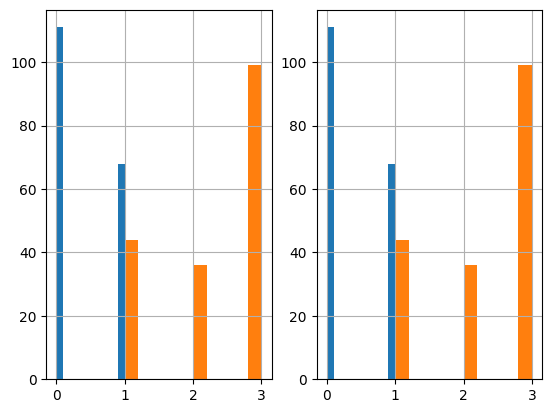

In [6]:
plt.subplot(1,2,1)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()


In [7]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 415 to 66
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  179 non-null    int64  
 1   Survived     179 non-null    int64  
 2   Pclass       179 non-null    int64  
 3   Name         179 non-null    object 
 4   Sex          179 non-null    object 
 5   Age          138 non-null    float64
 6   SibSp        179 non-null    int64  
 7   Parch        179 non-null    int64  
 8   Ticket       179 non-null    object 
 9   Fare         179 non-null    float64
 10  Cabin        35 non-null     object 
 11  Embarked     178 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 18.2+ KB


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer (BaseEstimator, TransformerMixin):

    def fit (self, X, y=None):
        return self
    
    def transform (self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [9]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder (BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()

        column_names = ["C", "S", "Q", "N"]

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[['Sex']]).toarray()

        column_names = ["Female","Male"]

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X

In [11]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")
    

In [12]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()), 
                     ("featureencoder", FeatureEncoder()), 
                     ("featuredropper", FeatureDropper())])

In [13]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [14]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
273,274,0,1,37.0,0,1,29.7000,1.0,0.0,0.0,0.0,1.0
622,623,1,3,20.0,1,1,15.7417,1.0,0.0,0.0,0.0,1.0
253,254,0,3,30.0,1,0,16.1000,0.0,0.0,1.0,0.0,1.0
171,172,0,3,4.0,4,1,29.1250,0.0,1.0,0.0,0.0,1.0
219,220,0,2,30.0,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
655,656,0,2,24.0,2,0,73.5000,0.0,0.0,1.0,0.0,1.0
569,570,1,3,32.0,0,0,7.8542,0.0,0.0,1.0,0.0,1.0
722,723,0,2,34.0,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
429,430,1,3,32.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [15]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 415 to 66
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  179 non-null    int64  
 1   Survived     179 non-null    int64  
 2   Pclass       179 non-null    int64  
 3   Name         179 non-null    object 
 4   Sex          179 non-null    object 
 5   Age          138 non-null    float64
 6   SibSp        179 non-null    int64  
 7   Parch        179 non-null    int64  
 8   Ticket       179 non-null    object 
 9   Fare         179 non-null    float64
 10  Cabin        35 non-null     object 
 11  Embarked     178 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 18.2+ KB


In [16]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop('Survived', axis=1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10,100,200,500], "max_depth": [None,5,10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)



GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [22]:
final_clf = grid_search.best_estimator_


In [23]:
final_clf

RandomForestClassifier(max_depth=5, n_estimators=200)

In [24]:
strat_test_set = pipeline.fit_transform(strat_test_set)


In [25]:
X_test = strat_test_set.drop('Survived', axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_test_data = scaler.fit_transform(X_test)
y_test_data = y_test.to_numpy()

In [26]:
final_clf.score(X_test_data, y_test_data)

0.8324022346368715

In [28]:
final_data = pipeline.fit_transform(titanic_data)

In [29]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [30]:
X_final = final_data.drop('Survived', axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [31]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10,100,200,500], "max_depth": [None,5,10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [32]:
prod_final_clf = grid_search.best_estimator_

In [33]:
prod_final_clf

RandomForestClassifier(max_depth=5, min_samples_split=4, n_estimators=500)

In [34]:
titanic_test_data = pd.read_csv('test.csv')

In [36]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [37]:
final_test_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [38]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

/var/folders/2t/j1l_7lxd0fv58b7lx9mbstyr0000gn/T/ipykernel_1400/1896703401.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [39]:
predictions = prod_final_clf.predict(X_data_final_test)

In [40]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv('predictions.csv', index=False)

In [41]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
